In [262]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import typing as ty

# setting dark background
plt.style.use('dark_background')

In [263]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [264]:
path = 'cifar-10-batches-py/data_batch_1'
dict = unpickle(path)
labels = dict[b'labels']
data = dict[b'data']
images = [None]*10
for i in range(10):
    image = data[labels.index(i)].reshape(3,32,32).transpose(1,2,0)
    images[i] = image

kernel and activation functions

In [265]:
# kernels
def kernel( name: str = 'box_blur', k : int = 3 ) -> np.ndarray:
    """
    Parameters
    ---------
    k : int
        size of kernel
    name : {'box_blur','identity','unsharp_mask','gaussian_blur','progressive','asymmetric_example'}
        'box_blur' : blurs the image
        'identity' : would return the same image
        'unsharp_mask' : unsharp mask filter
        'gaussian_blur' : gaussian blur filter
        'progressive; : progressive filter
        'asymmetric_example' : asymmetric filter
    Returns
    -------
    out : ndarray
        3 dimensional k x k x c numpy array
    """
    if name == 'box_blur':
        return np.ones((k,k,3))/(3*k**2)
    elif name == "identity":
        temp = np.zeros((k,k,3))
        temp[k//2,k//2,:] = 1
        return temp
    elif name == "unsharp_mask":
        temp = np.zeros((k,k))
        variance = ((k-1)/5.5)**2
        for i in range(k):
            for j in range(k):
                temp[i][j] = np.exp(-((i-k//2)**2+(j-k//2)**2)/(2*variance))
        temp/=np.sum(temp)*3
        temp[k//2,k//2] -= 2
        temp = -temp
        return np.dstack((temp,temp,temp))
    elif name == "gaussian_blur":
        temp = np.zeros((k,k))
        variance = ((k-1)/5.5)**2
        for i in range(k):
            for j in range(k):
                temp[i][j] = np.exp(-((i-k//2)**2+(j-k//2)**2)/(2*variance))
        temp/= np.sum(temp)*3
        return np.dstack((temp,temp,temp))
    elif name == "progressive":
        temp = np.arange(k**2)+1
        temp = temp.reshape((k,k))/(((k+1)*(k+2))**2/(4/3))
        return np.dstack((temp,temp,temp))
    elif name == "asymmetric_example":
        temp = np.zeros((k,k))
        temp[0,0] = 1
        temp[-1,-1] = -1
        return np.dstack((temp,temp,temp))
    else:
        raise ValueError("{} is not a valid name for kernel in this function".format(name))     

# activation functions

def sigmoid(x : ty.Union[float, np.ndarray]) -> ty.Union[float, np.ndarray]:
    """sigmoid function
    
    returns 1/(1+exp(-x))"""
    return 1/(1+np.exp(-x))

def tanh(x: ty.Union[float, np.ndarray]) -> ty.Union[float, np.ndarray]:
    """tanh function
    
    returns tanh(x)"""
    return np.tanh(x)

def relu(x : ty.Union[float, np.ndarray]) -> ty.Union[float, np.ndarray]:
    """ReLU function
    
    returns max(0,x)"""
    return np.maximum(0,x)

def prelu(x : ty.Union[float, np.ndarray], sigma : float ) -> ty.Union[float, np.ndarray]:
    """parametric ReLU function
    
    returns max(sigma x, x)
    """
    return np.maximum(sigma*x, x)

def softmax(x : np.ndarray) -> np.ndarray:
    """Softmax function
    
    return [e^x_i/sum(e^x_i) for all i]"""
    denom = np.sum(np.exp(x))
    return np.exp(x)/denom

lambda_prelu = lambda sigma: (lambda x: prelu(x,sigma))

# max pooling
max_pool = lambda x: np.max(x)
# average pooling
avg_pool = lambda x: np.mean(x)

In [266]:
def convolution(img : np.ndarray, kernel : np.ndarray, stride : int = 1, non_linearity: ty.Union[str, ty.Callable[[float],float]] = 'sigmoid', padding : int = 1) -> np.ndarray:
    """
    Parameters
    ---------
    non_linearity : { 'sigmoid', 'tanh', 'ReLU', 'prelu' }

    Returns the convoluted image"""

    dispatcher = {'sigmoid':sigmoid, 'tanh': tanh, 'ReLU': relu, 'pReLU': lambda_prelu(0.05) }

    # making non_linearity callable
    if isinstance(non_linearity, str):
        try:
            non_linearity = dispatcher[non_linearity]
        except:
            raise KeyError("{} is not a valid non-linearity".format(non_linearity))
    
    # kernel and image sizes
    kernel_size = kernel.shape
    img_size = img.shape

    # dimensions of image
    W, H = img_size[:2]
    c = 1
    # dimension of kernel
    k = kernel_size[0]
    assert kernel_size[0] == kernel_size[1], "kernel should be a k x k x c matrix"

    if kernel_size.__len__() == 3:
        assert kernel_size[-1] == img_size[-1], "The kernel should have number of channels as the image"
        c = img_size[-1]

    assert padding < min(img_size[:2]), "Padding shouldn't be too large"

    # flipped images
    horizontal_flipped = img[::-1]
    vertical_flipped = img[:,::-1]
    fully_flipped = img[::-1,::-1]

    # creating padded image
    if padding:
        padded_array = np.zeros((W+2*padding, H+2*padding,c))
        padded_array[padding:-padding,padding:-padding] = img.copy()
        padded_array[:padding,:padding] = fully_flipped[-padding:,-padding:]
        padded_array[-padding:,-padding:] = fully_flipped[:padding,:padding]
        padded_array[:padding,-padding:] = fully_flipped[-padding:,:padding]
        padded_array[-padding:,:padding] = fully_flipped[:padding,-padding:]
        padded_array[:padding,padding:-padding] = horizontal_flipped[-padding:,:]
        padded_array[-padding:,padding:-padding] = horizontal_flipped[:padding,:]
        padded_array[padding:-padding,:padding] = vertical_flipped[:,-padding:]
        padded_array[padding:-padding,-padding:] = vertical_flipped[:,:padding]
    else:
        padded_array = img.copy()
        
    output = np.zeros(( 1+(W+2*padding-k)//stride, 1+(H+2*padding-k)//stride ))
    x,y = 0,0
    for i in range(0, W+1+2*padding-k, stride):
        for j in range(0, H+1+2*padding-k, stride):
            output[x,y] = non_linearity(np.sum(padded_array[i:i+k,j:j+k,:]*kernel))            
            y += 1
            
        x += 1
        y = 0
        
    return output
    

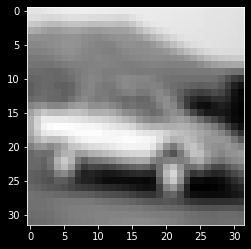

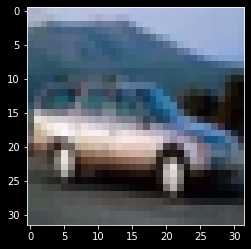

In [267]:
img = images[1]
img_out = convolution(img, kernel('box_blur')/100)
plt.imshow(img_out, cmap = 'gray')
plt.show()
plt.imshow(images[1])
plt.show()

In [268]:
def pool(img: np.ndarray, pooling_func : ty.Callable[[np.ndarray],float], stride : float, display : bool = True) -> np.ndarray:
    W,H = img.shape[:2]
    output = np.zeros( ( (W-2)//stride+1, (H-2)//stride +1 ) )
    x,y = 0,0
    for i in range(0,W,stride):
        for j in range(0,H,stride):
            output[x,y] = pooling_func(img[i:i+2,j:j+2])
            y+=1
        x+=1
        y=0
    
    if display:
        fig, ax = plt.subplots(1,2, figsize = (5,12))
        fig.tight_layout(pad=1.0)
        ax[0].imshow(img, cmap = 'gray')
        ax[0].set_title("before pooling")
        ax[1].imshow(output, cmap = 'gray')
        ax[1].set_title("after pooling")
        return output, ax
    return output
    

Shape before pooling (32, 32) ,shape after pooling (16, 16)


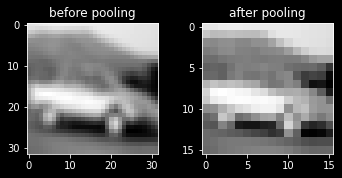

In [269]:
output, ax = pool(img_out, max_pool,2)
print("Shape before pooling",img_out.shape,",shape after pooling",output.shape)
plt.show()

In [270]:
def conv_layer_func( img: np.ndarray, kernels : ty.Tuple[np.ndarray],stride : float = 1, non_linearity: ty.Union[str, ty.Callable[[float],float]] = 'sigmoid', padding : int = 1) -> np.ndarray:
    
    dispatcher = {'sigmoid':sigmoid, 'tanh': tanh, 'ReLU': relu, 'pReLU': lambda_prelu(0.05) }

    # making non_linearity callable
    if isinstance(non_linearity, str):
        try:
            non_linearity = dispatcher[non_linearity]
        except:
            raise KeyError("{} is not a valid non-linearity".format(non_linearity))

    output = []
    for kernel in kernels:
        temp = convolution(img, kernel, stride, non_linearity, padding)
        output.append(temp)
    output = np.dstack(list(temp for temp in output))
    return output

kernels = (kernel(), kernel('asymmetric_example'), kernel('unsharp_mask'), kernel('gaussian_blur'), kernel('progressive'),\
    kernel('identity'))
output = conv_layer_func(img, [kernel/200 for kernel in kernels])

volume: (32, 32, 6) for 6 kernels


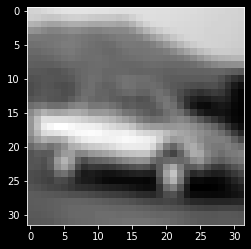

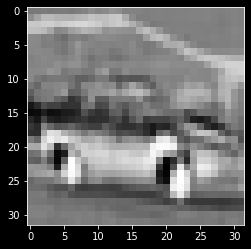

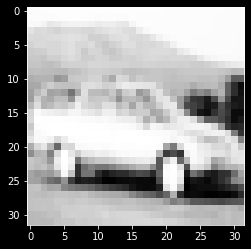

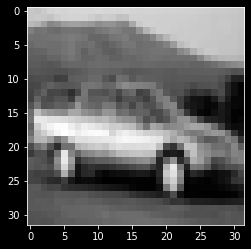

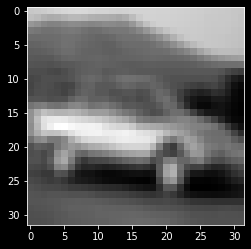

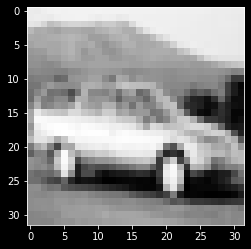

In [271]:
print("volume:",output.shape, "for 6 kernels")
for i in range(output.shape[-1]):
    plt.imshow(output[:,:,i], cmap = 'gray')
    plt.show()

In [272]:
def pooling_layer_func( img: np.ndarray, pooling_func : ty.Callable[[np.ndarray], float], stride : float):
    W, H, C = img.shape
    output = np.zeros(( (W-2)//stride+1, (H-2)//stride +1, C ) )
    for i in range(C):
        output[:,:,i] = pool(img[:,:,i], pooling_func, stride, display = False)
    return output


In [273]:
output = pooling_layer_func(output, max_pool, 2)

volume: (16, 16, 6) for 6 kernels, stride =2, max pooling


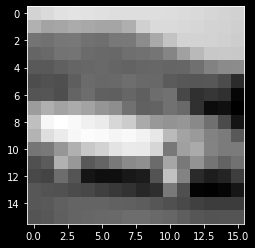

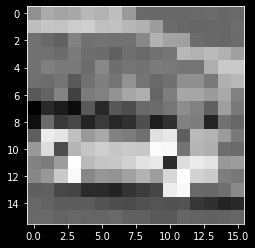

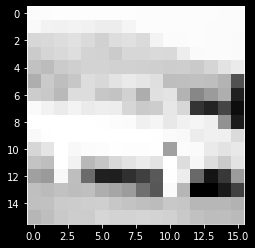

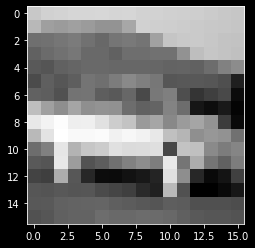

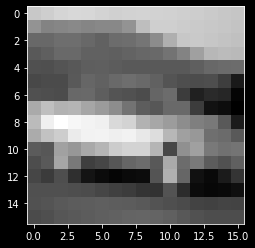

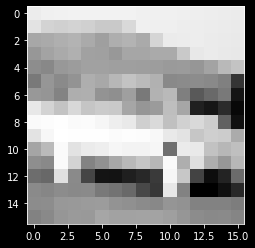

In [274]:
print("volume:",output.shape, "for 6 kernels, stride =2, max pooling")
for i in range(output.shape[-1]):
    plt.imshow(output[:,:,i], cmap = 'gray')
    plt.show()

In [275]:
def flattening(img : np.ndarray, weight_matrix : np.ndarray) -> float:
    img_flatten = img.flatten()
    return weight_matrix @ img_flatten

In [276]:

def mlp(inp_layer : np.ndarray, n_hidden : int, size_hidden : ty.Tuple[int], non_linearity : ty.Callable[[np.ndarray], np.ndarray], output_size : int):
    np.random.seed(0)
    next_layer = inp_layer
    for i in range(n_hidden):
        hidden_weights = np.random.random(( size_hidden[i], next_layer.shape[0]))/100
        next_layer = non_linearity(hidden_weights @ next_layer)

    # for output
    output_layer_weights = np.random.random((output_size, next_layer.shape[0]))/100
    output_layer = softmax(output_layer_weights @ next_layer)
    return output_layer

In [277]:
def feed_forward_path(img: np.ndarray, ret_flatten: bool = False) -> np.ndarray:
    np.random.seed(0)
    kernels = []
    for i in range(16):
        kernels.append(np.random.random((3,3,3))/1000) # take 16 kernels of size 3 x 3 x 3
    kernels = tuple(kernels)
    output_img = conv_layer_func(img, kernels)
    pooled_output_img = pooling_layer_func(output_img, max_pool, stride = 2)

    # take 8 kernels of size 3 x 3 x 16
    kernels = []
    for i in range(8):
        kernels.append(np.random.random((3,3,16))/1000) 
    kernels = tuple(kernels)
    conv_again_img = conv_layer_func(pooled_output_img, kernels )
    pooled_again_output_img = pooling_layer_func(conv_again_img, max_pool, stride = 2)

    weight_matrix = None # take square weight matrix of size pooled_again_output_img
    s = pooled_again_output_img.flatten().shape[0]
    weight_matrix = np.random.random((s//4,s))/100
    flattened_output = flattening(pooled_again_output_img, weight_matrix)
    if ret_flatten:
        return flattened_output
    size_of_hidden = 20
    output = mlp(flattened_output, 1, (size_of_hidden,), sigmoid, 10)
    return output

In [278]:
# testing
img = images[0]
feed_forward_path(img)

array([0.09925304, 0.0996532 , 0.10088399, 0.10076807, 0.10024652,
       0.10109359, 0.10000525, 0.09960933, 0.09965205, 0.09883495])

In [279]:
output = []
for label, image in enumerate(images):
    output.append({label : feed_forward_path(image)})
print(output)

[{0: array([0.09925304, 0.0996532 , 0.10088399, 0.10076807, 0.10024652,
       0.10109359, 0.10000525, 0.09960933, 0.09965205, 0.09883495])}, {1: array([0.09925335, 0.09965337, 0.10088361, 0.10076775, 0.10024641,
       0.10109312, 0.10000526, 0.09960949, 0.0996522 , 0.09883545])}, {2: array([0.09925317, 0.09965327, 0.10088383, 0.10076793, 0.10024647,
       0.10109339, 0.10000526, 0.0996094 , 0.09965211, 0.09883517])}, {3: array([0.09925386, 0.09965364, 0.10088298, 0.10076721, 0.10024623,
       0.10109234, 0.10000528, 0.09960976, 0.09965244, 0.09883627])}, {4: array([0.09925373, 0.09965357, 0.10088314, 0.10076734, 0.10024627,
       0.10109254, 0.10000528, 0.09960969, 0.09965238, 0.09883607])}, {5: array([0.0992538 , 0.09965361, 0.10088305, 0.10076727, 0.10024625,
       0.10109243, 0.10000528, 0.09960973, 0.09965241, 0.09883617])}, {6: array([0.09925338, 0.09965339, 0.10088357, 0.10076771, 0.1002464 ,
       0.10109307, 0.10000526, 0.09960951, 0.09965221, 0.0988355 ])}, {7: array([0

There is not much of a trend here, the output vectors seem almost the same.

A randomly initialized network doesn't show any discriminability.

In [280]:
images = {}
for i in range(10):
    images[i]=[]

for i in range(len(data)):
    images[labels[i]].append(data[i].reshape(3,32,32).transpose(1,2,0))

In [281]:
outputs = []
for i in range(10):
    for j in range(3):
        img = images[i][j]
        outputs.append(feed_forward_path(img, ret_flatten = True))
outputs = np.array(outputs)


In [282]:
outputs.shape

(30, 128)

In [287]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',perplexity=2).fit_transform(outputs)

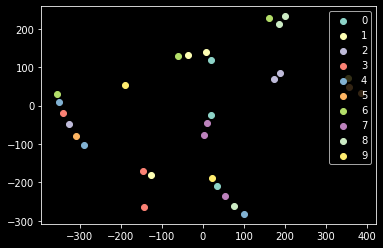

In [288]:
for i in range(10):
    plt.scatter(X_embedded[3*i:3*(i+1), 0], X_embedded[3*i:3*(i+1), 1], label = "{}".format(i))
    plt.legend()
plt.show()